In [91]:
import torch
from torch import nn
import numpy as np

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import pdb
import pytorch_lightning as pl

import matplotlib.pyplot as plt
from PIL import Image

import cv2

import os

In [92]:
device = torch.device('cuda' if torch.cuda.is_available is True else 'cpu')

Data Loading


In [138]:
def data_load_test(good, bad):
  fig,axs = plt.subplots(1,2, figsize=(15,15))
  axs[0].imshow(np.transpose(torchvision.utils.make_grid(good,nrow=8, padding=True),(1,2,0)))
  axs[0].title.set_text('Original Image')
  axs[1].imshow(np.transpose(torchvision.utils.make_grid(bad,nrow=8, padding=True),(1,2,0)))
  axs[1].title.set_text('Corrupted Image')
  axs[0].axis('off')
  axs[1].axis('off')
  plt.show()
    

In [98]:
def load_data():
  class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i][0] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

  corrupt_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomAffine(degrees=(-50,50), scale=(0.8,1.2), shear=(10,10,10,10)),
    ])

  train_dataset_good = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
  test_dataset_good = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

  train_dataset_bad = torchvision.datasets.MNIST(root='./data', train=True, transform=corrupt_transforms, download=True)
  test_dataset_bad = torchvision.datasets.MNIST(root='./data', train=False, transform=corrupt_transforms, download=True)


  train_set_size = int(len(train_dataset_good)*0.8)
  valid_set_size = len(train_dataset_good) - train_set_size

  train_set_good, valid_set_good = random_split(train_dataset_good, [train_set_size, valid_set_size])
  train_set_bad, valid_set_bad = random_split(train_dataset_bad, [train_set_size,valid_set_size])

  train_loader = torch.utils.data.DataLoader(
              ConcatDataset(train_set_good, train_set_bad),
              batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

  valid_loader = torch.utils.data.DataLoader(
              ConcatDataset(valid_set_good, valid_set_bad),
              batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

  test_loader = torch.utils.data.DataLoader(
              ConcatDataset(test_dataset_good, test_dataset_bad),
              batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
  
  return(train_loader,valid_loader, test_loader)


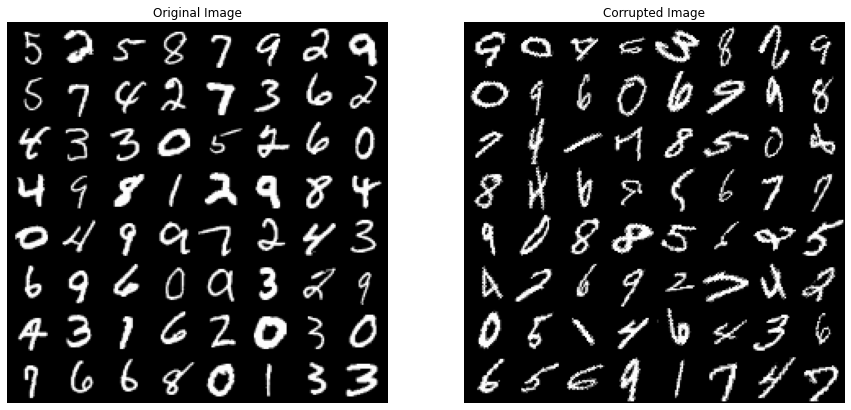

In [99]:
data_load_test()


Generator Model

In [100]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

In [101]:
class unet_encoder(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

In [102]:
class unet_decoder(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x
       
    

In [103]:
class Unet(nn.Module):
  def __init__(self):
    super().__init__()

    #Encoder
    self.e1 = unet_encoder(1,64)
    self.e2 = unet_encoder(64,128)
   
    #bottleneck
    self.bottle = conv_block(128,256)

    #decoder
    self.d1 = unet_decoder(256,128)
    self.d2 = unet_decoder(128,64)

    #final layer
    self.final = nn.Conv2d(64,1,kernel_size=1)

  def forward(self,inputs):
    #Encoder
    s1,p1 = self.e1(inputs)
    s2,p2 = self.e2(p1)

    #Bottleneck
    b = self.bottle(p2)
  #  print(f'Bottleneck Shape {b.shape}')
    #decoder
    d1 = self.d1(b,s2)
    d2 = self.d2(d1,s1)
 #   print(f'last shape {d2.shape}')
    #classifier
    output = self.final(d2)

    return output



Sanity Check for Unet

In [104]:
# conv block test
inputs = torch.randn((2,1,28,28))
con = conv_block(1,64)
x = con(inputs)
print(f'Conv Block output: {x.shape}')

# encoder block test
inputs = torch.randn((2,1,28,28))
enc = unet_encoder(1,64)
y = enc(inputs)
print(f'Encoder output: {y[0].shape}, {y[1].shape}')

#decoder block test
inputs = torch.randn((2,256,7,7))
skip = torch.randn((2,128,14,14))
dec = unet_decoder(256,128)
z = dec(inputs,skip)
print(f'Decoder output: {z.shape}')

#test unet
inputs = torch.randn((2,1,28,28))
model = Unet()
fin = model(inputs)
print(f'Final Output {fin.shape}')

Conv Block output: torch.Size([2, 64, 28, 28])
Encoder output: torch.Size([2, 64, 28, 28]), torch.Size([2, 64, 14, 14])
Decoder output: torch.Size([2, 128, 14, 14])
Final Output torch.Size([2, 1, 28, 28])


Discriminator Model

In [105]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.relu = nn.ReLU()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding='same', padding_mode='reflect')
    self.pool1 = nn.MaxPool2d(kernel_size=(2,2))
    
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding='same', padding_mode='reflect')
    self.pool2 = nn.MaxPool2d(kernel_size=(2,2))

    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same', padding_mode='reflect')
    self.pool3 = nn.MaxPool2d(kernel_size=(2,2))

    self.fc1 = nn.Linear(64*3*3, 256)
    self.fc2 = nn.Linear(256,1)

    self.sig = nn.Sigmoid()

  def forward(self,inputs):
    x = self.pool1(self.relu(self.conv1(inputs)))
    x = self.pool2(self.relu(self.conv2(x)))
    x = self.pool3(self.relu(self.conv3(x)))

    x = x.view(-1,64*3*3)

    x = self.fc1(x)
    x = self.fc2(x)
    x = self.sig(x)
    
    return x


Adversarial Training

In [131]:
class GAN(pl.LightningModule):
 
  def __init__(self):
    super().__init__()

    self.batch_size = 64
    #transforms
    self.corrupt_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomAffine(degrees=(-50,50), scale=(0.8,1.2), shear=(10,10,10,10)),
    ])
    #loss
    self.bce = nn.BCELoss()
    #generator
    self.generator = Unet()
    #discriminator
    self.discriminator = Discriminator()

    #set automatic optimization false
    self.automatic_optimization = False


  def forward(self, x):
    z = self.generator(x)
    return z

  def configure_optimizers(self):
    g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=1e-4)
    d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=1e-4)

    return g_optimizer, d_optimizer

  def training_step(self, batch, batch_idx):
    good_img, bad_img = batch
    
    g_optimizer, d_optimizer = self.optimizers()

    real_label = torch.ones(good_img.size(0),1)
    real_label = real_label.type_as(good_img)

    fake_label = torch.zeros(good_img.size(0),1)
    fake_label = fake_label.type_as(good_img)

    translated_img = self.generator(bad_img)
    
    #train discriminator
    dis_good = self.discriminator(good_img)
    real_loss = self.bce(dis_good, real_label)

    dis_translated = self.discriminator(translated_img.detach())
    fake_loss = self.bce(dis_translated, fake_label)

    disc_loss = (real_loss + fake_loss)/2

    d_optimizer.zero_grad()
    self.manual_backward(disc_loss)
    d_optimizer.step()

    #train generator
    dis_translated = self.discriminator(translated_img)
    gen_loss = self.bce(dis_translated, real_label)

    g_optimizer.zero_grad()
    self.manual_backward(gen_loss)
    g_optimizer.step()

    self.log_dict({'g_loss':gen_loss, 'd_loss':disc_loss}, prog_bar=True)

  def validation_step(self, batch, batch_idx):
    with torch.no_grad():
      good_img, bad_img = batch

      real_label = torch.ones(good_img.size(0),1)
      real_label = real_label.type_as(good_img)

      fake_label = torch.zeros(good_img.size(0),1)
      fake_label = fake_label.type_as(good_img)

      translated_img = self.generator(bad_img)
      
      #validate discriminator
      dis_good = self.discriminator(good_img)
      real_loss = self.bce(dis_good, real_label)

      dis_translated = self.discriminator(translated_img.detach())
      fake_loss = self.bce(dis_translated, fake_label)

      disc_loss = (real_loss + fake_loss)/2

      #validate generator
      dis_translated = self.discriminator(translated_img)
      gen_loss = self.bce(dis_translated, real_label)
      
      self.log_dict({'g_loss': gen_loss, 'd_loss':disc_loss}, prog_bar=True)


  def setup(self, stage=None):
    if stage == "fit" or stage is None:
        train_dataset_good = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
        train_dataset_bad = torchvision.datasets.MNIST(root='./data', train=True, transform=self.corrupt_transforms, download=True)

        train_set_size = int(len(train_dataset_good)*0.8)
        valid_set_size = len(train_dataset_good) - train_set_size

        self.train_set_good, self.valid_set_good = random_split(train_dataset_good, [train_set_size, valid_set_size])
        self.train_set_bad, self.valid_set_bad = random_split(train_dataset_bad, [train_set_size,valid_set_size])

    if stage == "test" or stage is None:
        self.test_set_good = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
        self.test_dataset_bad = torchvision.datasets.MNIST(root='./data', train=False, transform=self.corrupt_transforms, download=True)
  
  def train_dataloader(self):
    train_loader =  torch.utils.data.DataLoader(
              self.ConcatDataset(self.train_set_good, self.train_set_bad),
              batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True)
    return train_loader

  def val_dataloader(self):
    val_loader = torch.utils.data.DataLoader(
              self.ConcatDataset(self.valid_set_good, self.valid_set_bad),
              batch_size=self.batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return val_loader

  def test_dataloader(self):
    test_loader = torch.utils.data.DataLoader(
              self.ConcatDataset(self.test_set_good, self.test_set_bad),
              batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True)
    return test_loader



  class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i][0] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

In [132]:
model = GAN()

In [133]:
trainer = pl.Trainer(max_epochs=10, accelerator='gpu')
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | bce           | BCELoss       | 0     
1 | generator     | Unet          | 1.9 M 
2 | discriminator | Discriminator | 171 K 
------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.142     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:469: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1adb4a170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1adb4a170>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1adb4a170>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1adb4a170>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

In [135]:
train_loader,valid_loader, test_loader= load_data()

In [140]:
sample = next(iter(train_loader))
good_sample, bad_sample = sample

In [144]:
my_gen = model.generator

In [156]:
predictor = pl.Trainer(accelerator='gpu')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
predictor.predict(model, test_loader)